# Importing Libraries and Dataset

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import zipfile
import os
zipref = zipfile.ZipFile("/content/drive/MyDrive/lanedetection.zip")
zipref.extractall()
zipref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/lanedetection.zip' mode='r'>>

In [ ]:
x_train_dir = os.path.join('/content/train')
y_train_dir = os.path.join('/content/train_label')

x_val_dir = os.path.join('/content/val')
y_val_dir = os.path.join('/content/val_label')

In [ ]:
train_imgs = os.listdir(x_train_dir)

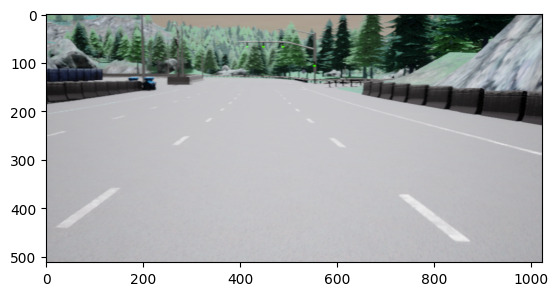

In [ ]:
img = plt.imread(os.path.join("train", train_imgs[0]))
plt.imshow(img)
plt.show()

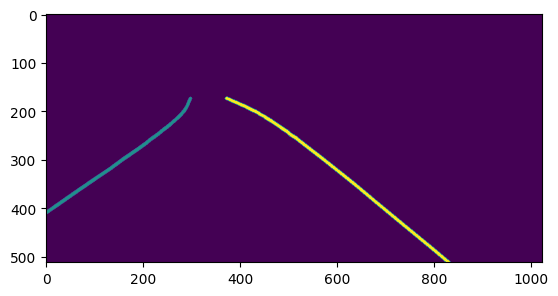

In [ ]:
train_labels = os.listdir(y_train_dir)
img = plt.imread(os.path.join("train_label", train_labels[0]))
plt.imshow(img)
plt.show()

In [ ]:
#yolov3.py
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, \
    Input, ZeroPadding2D, LeakyReLU, UpSampling2D
def parse_cfg(cfgfile):
    with open(cfgfile, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    holder = {}
    blocks = []
    for line in lines:
        if line[0] == '[':
            line = 'type=' + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks
def YOLOv3Net(cfgfile, model_size, num_classes):
    blocks = parse_cfg(cfgfile)
    outputs = {}
    output_filters = []
    filters = []
    out_pred = []
    scale = 0
    inputs = input_image = Input(shape=model_size)
    inputs = inputs / 255.0
    for i, block in enumerate(blocks[1:]):
        # If it is a convolutional layer
        if (block["type"] == "convolutional"):
            activation = block["activation"]
            filters = int(block["filters"])
            kernel_size = int(block["size"])
            strides = int(block["stride"])
            if strides > 1:
                inputs = ZeroPadding2D(((1, 0), (1, 0)))(inputs)
            inputs = Conv2D(filters,
                            kernel_size,
                            strides=strides,
                            padding='valid' if strides > 1 else 'same',
                            name='conv_' + str(i),
                            use_bias=False if ("batch_normalize" in block) else True)(inputs)
            if "batch_normalize" in block:
                inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
            #if activation == "leaky":
                inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)
        elif (block["type"] == "upsample"):
            stride = int(block["stride"])
            inputs = UpSampling2D(stride)(inputs)
        # If it is a route layer
        elif (block["type"] == "route"):
            block["layers"] = block["layers"].split(',')
            start = int(block["layers"][0])
            if len(block["layers"]) > 1:
                end = int(block["layers"][1]) - i
                filters = output_filters[i + start] + output_filters[end]  # Index negatif :end - index
                inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
            else:
                filters = output_filters[i + start]
                inputs = outputs[i + start]
        elif block["type"] == "shortcut":
            from_ = int(block["from"])
            inputs = outputs[i - 1] + outputs[i + from_]
        # Yolo detection layer
        elif block["type"] == "yolo":
            mask = block["mask"].split(",")
            mask = [int(x) for x in mask]
            anchors = block["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]
            n_anchors = len(anchors)
            out_shape = inputs.get_shape().as_list()
            inputs = tf.reshape(inputs, [-1, n_anchors * out_shape[1] * out_shape[2], \
           5 + num_classes])
            box_centers = inputs[:, :, 0:2]
            box_shapes = inputs[:, :, 2:4]
            confidence = inputs[:, :, 4:5]
            classes = inputs[:, :, 5:num_classes + 5]
            box_centers = tf.sigmoid(box_centers)
            confidence = tf.sigmoid(confidence)
            classes = tf.sigmoid(classes)
            anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
            box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32)
            x = tf.range(out_shape[1], dtype=tf.float32)
            y = tf.range(out_shape[2], dtype=tf.float32)
            cx, cy = tf.meshgrid(x, y)
            cx = tf.reshape(cx, (-1, 1))
            cy = tf.reshape(cy, (-1, 1))
            cxy = tf.concat([cx, cy], axis=-1)
            cxy = tf.tile(cxy, [1, n_anchors])
            cxy = tf.reshape(cxy, [1, -1, 2])
            strides = (input_image.shape[1] // out_shape[1], \
                       input_image.shape[2] // out_shape[2])
            box_centers = (box_centers + cxy) * strides
            prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)
            if scale:
                out_pred = tf.concat([out_pred, prediction], axis=1)
            else:
                out_pred = prediction
                scale = 1
        outputs[i] = inputs
        output_filters.append(filters)
    model = Model(input_image, out_pred)
    model.summary()
    return model

In [ ]:
#convert_weights.py
import numpy as np

def load_weights(model,cfgfile,weightfile):
    # Open the weights file
    fp = open(weightfile, "rb")

    # Skip 5 header values
    np.fromfile(fp, dtype=np.int32, count=5)

    # The rest of the values are the weights
    blocks = parse_cfg(cfgfile)

    for i, block in enumerate(blocks[1:]):

        if (block["type"] == "convolutional"):
            conv_layer = model.get_layer('conv_' + str(i))
            print("layer: ",i+1,conv_layer)

            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if "batch_normalize" in block:

                norm_layer = model.get_layer('bnorm_' + str(i))
                print("layer: ",i+1,norm_layer)
                size = np.prod(norm_layer.get_weights()[0].shape)

                bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            else:
                conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(
                fp, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if "batch_normalize" in block:
                norm_layer.set_weights(bn_weights)
                conv_layer.set_weights([conv_weights])
            else:
                conv_layer.set_weights([conv_weights, conv_bias])

    assert len(fp.read()) == 0, 'failed to read all data'
    fp.close()


def main():

    weightfile = "/content/drive/MyDrive/yolov3.weights"
    cfgfile = "/content/drive/MyDrive/yolov3.cfg"

    model_size = (416, 416, 3)
    num_classes = 80

    model=YOLOv3Net(cfgfile,model_size,num_classes)
    load_weights(model,cfgfile,weightfile)

    try:
        model.save_weights('/content/yolov3_weights.tf')
        print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
    except IOError:
        print("Couldn't write the file \'yolov3_weights.tf\'.")


if __name__ == '__main__':
    main()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 416, 416, 3)          0         ['input_1[0][0]']             
 a)                                                                                               
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv[0][0]']     
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']          

<ipython-input-8-af9de909447e>:64: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  load_weights(model,cfgfile,weightfile)


layer:  6 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x790039bcf610>
layer:  6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790039bcc6a0>
layer:  7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x790039bcc310>
layer:  7 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790039bcc850>
layer:  8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x790038b9e740>
layer:  8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790038b9f1c0>
layer:  10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x790038b9f5b0>
layer:  10 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x790038505bd0>
layer:  11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x790038b9c6d0>
layer:  11 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x79003b59a2f0>
layer:  13 <keras.src.layers.convolutional.conv2d.C

In [ ]:
import cv2
import numpy as np
import os

weightfile = "/content/drive/MyDrive/yolov3.weights"
cfgfile = "/content/drive/MyDrive/yolov3.cfg"

model_size = (416, 416, 3)
num_classes = 80

model = YOLOv3Net(cfgfile, model_size, num_classes)

x_train_dir = "/content/train"
train_imgs = os.listdir(x_train_dir)

def increase_contrast(image):
    image = (image).astype(np.uint8)
    enhanced_image = cv2.equalizeHist(image)
    return enhanced_image

for img_name in train_imgs:
    img_path = os.path.join(x_train_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
        vertices_roi = np.array([[(0, image.shape[0]), (image.shape[1] // 2, image.shape[0] // 2),
                                  (image.shape[1], image.shape[0])]], dtype=np.int32)
        roi_mask = np.zeros_like(image)
        cv2.fillPoly(roi_mask, vertices_roi, (255, 255, 255))
        masked_image = cv2.bitwise_and(image, roi_mask)

    def preprocess(image):
        resized_image = cv2.resize(image, (416, 416))
        resized_image = resized_image / 255.0
        resized_image = np.expand_dims(resized_image, axis=0)
        resized_image = np.expand_dims(resized_image, axis=3)
        return resized_image

    preprocessed_image = preprocess(masked_image)

    enhanced_image = np.expand_dims(increase_contrast(preprocessed_image), axis=0)
    enhanced_image = np.expand_dims(enhanced_image, axis=3)


    predictions = model.predict(enhanced_image)

    for prediction in predictions:
      x, y, w, h = prediction[:4]
      confidence = prediction[4]
      class_label = np.argmax(prediction[5:])
      color = (0, 255, 0)
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imshow("Lane Detection", image)
    cv2.waitKey(0)

cv2.destroyAllWindows()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_19 (TFOpLa  (None, 416, 416, 3)          0         ['input_20[0][0]']            
 mbda)                                                                                            
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv_19[0][0]']  
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']       

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_19" is incompatible with the layer: expected shape=(None, 416, 416, 3), found shape=(None, 1, 416, 1)


In [ ]:
import cv2
import numpy as np
import os

weightfile = "/content/drive/MyDrive/yolov3.weights"
cfgfile = "/content/drive/MyDrive/yolov3.cfg"

model_size = (416, 416, 3)
num_classes = 80

model = YOLOv3Net(cfgfile, model_size, num_classes)

x_train_dir = "/content/train"
train_imgs = os.listdir(x_train_dir)



for img_name in train_imgs:
    img_path = os.path.join(x_train_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
        vertices_roi = np.array([[(0, image.shape[0]), (image.shape[1] // 2, image.shape[0] // 2),
                                  (image.shape[1], image.shape[0])]], dtype=np.int32)
        roi_mask = np.zeros_like(image)
        cv2.fillPoly(roi_mask, vertices_roi, (255, 255, 255))
        masked_image = cv2.bitwise_and(image, roi_mask)

        def preprocess(image):
          resized_image = cv2.resize(image, (416, 416))
          resized_image = resized_image / 255.0
          resized_image = np.expand_dims(resized_image, axis=0)
          return resized_image


        preprocessed_image = preprocess(masked_image)


        predictions = model.predict(preprocessed_image)

    for prediction in predictions:
      x, y, w, h = prediction[:4]
      confidence = prediction[4]
      class_label = np.argmax(prediction[5:])
      color = (0, 255, 0)
      print(x,y,w,h)
      print(type(image))
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imshow("Lane Detection", image)
    cv2.waitKey(0)

cv2.destroyAllWindows()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_23 (TFOpLa  (None, 416, 416, 3)          0         ['input_24[0][0]']            
 mbda)                                                                                            
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv_23[0][0]']  
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']       

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [ ]:
import cv2
import numpy as np
import os

weightfile = "/content/drive/MyDrive/yolov3.weights"
cfgfile = "/content/drive/MyDrive/yolov3.cfg"
model_size = (416, 416, 3)
num_classes = 80
model = YOLOv3Net(cfgfile, model_size, num_classes)


x_train_dir = "/content/train"
train_imgs = os.listdir(x_train_dir)

for img_name in train_imgs:
    img_path = os.path.join(x_train_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
        resized_image = cv2.resize(image, (model_size[1], model_size[0]))
        preprocessed_image = resized_image / 255.0

        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

        predictions = model.predict(preprocessed_image)


        for prediction in predictions:
            x, y, w, h = prediction[:4].astype(int)
            x = x.astype(int)
            y = y.astype(int)
            xw = (x + w)
            yh = (y + h)
            xw = xw.astype(int)
            yh = yh.astype(int)
            confidence = float(prediction[4][0])
            class_label = int(np.argmax(prediction[5:]))
            color = (0, 255, 0)
            print(x.dtype)
            print(y.dtype)
            print(w.dtype)
            print(h.dtype)
            cv2.rectangle(image, (x, y), (xw, yh), color, 2)
            cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        '''
        for prediction in predictions:
            x, y, w, h = map(int, prediction[:4])  # Convert to integers
            confidence = prediction[4]
            class_label = np.argmax(prediction[5:])
            color = (0, 255, 0)
            print(x, y, w, h)
            print(type(image))
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        '''

        cv2.imshow("Object Detection", image)
        cv2.waitKey(0)


cv2.destroyAllWindows()


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_35 (TFOpLa  (None, 416, 416, 3)          0         ['input_36[0][0]']            
 mbda)                                                                                            
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv_35[0][0]']  
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']       

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [ ]:
print(type(prediction))

<class 'numpy.ndarray'>


In [ ]:
print(prediction[4].shape)
print(prediction[4])

(85,)
[ 47.998856    15.997751   155.98383    197.97054      0.49996793
   0.4999444    0.49996537   0.50003153   0.49996054   0.4999671
   0.49996197   0.50010276   0.49988428   0.4999385    0.49993455
   0.5000422    0.49999654   0.5000125    0.49993193   0.4999649
   0.49998498   0.49997926   0.49986842   0.50009304   0.49997568
   0.4999609    0.4999835    0.5000724    0.50009376   0.49998784
   0.5000303    0.5001436    0.4999429    0.49994588   0.5000475
   0.5000406    0.5000327    0.4999534    0.49986795   0.49993038
   0.49989977   0.49994946   0.50003594   0.500112     0.49995208
   0.49993563   0.49997288   0.5000407    0.49997592   0.50003135
   0.50003356   0.500063     0.5000651    0.5000245    0.50004864
   0.49990562   0.49993372   0.4999801    0.49993104   0.49999857
   0.49991894   0.5001472    0.499959     0.5000593    0.5000299
   0.49991417   0.50003505   0.49991632   0.5000427    0.49999237
   0.49993598   0.5000714    0.49996728   0.50002354   0.49987665
   0.500

In [ ]:
import cv2
import numpy as np

weightfile = "/content/drive/MyDrive/yolov3.weights"
cfgfile = "/content/drive/MyDrive/yolov3.cfg"

model_size = (416, 416, 3)
num_classes = 80

model = YOLOv3Net(cfgfile, model_size, num_classes)

image = cv2.imread(os.path.join("train", train_imgs))

vertices_roi = np.array([[(0, image.shape[0]), (image.shape[1] // 2, image.shape[0] // 2),
                          (image.shape[1], image.shape[0])]], dtype=np.int32)
roi_mask = np.zeros_like(image)
cv2.fillPoly(roi_mask, vertices_roi, (255, 255, 255))
masked_image = cv2.bitwise_and(image, roi_mask)

def preprocess(image):
    resized_image = cv2.resize(image, (416, 416))
    resized_image = resized_image / 255.0
    resized_image = np.expand_dims(resized_image, axis=0)
    return resized_image

preprocessed_image = preprocess(masked_image)

def increase_contrast(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    enhanced_image = cv2.equalizeHist(gray_image)
    return enhanced_image

enhanced_image = increase_contrast(preprocessed_image)

predictions = model.predict(enhanced_image)

for prediction in predictions:
    x, y, w, h = prediction[:4]
    confidence = prediction[4]
    class_label = np.argmax(prediction[5:])
    color = (0, 255, 0)  # Green color for bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the result
cv2.imshow("Lane Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_3 (TFOpLam  (None, 416, 416, 3)          0         ['input_4[0][0]']             
 bda)                                                                                             
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv_3[0][0]']   
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']        

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [ ]:
import cv2
import numpy as np
import os

weightfile = "/content/drive/MyDrive/yolov3.weights"
cfgfile = "/content/drive/MyDrive/yolov3.cfg"

model_size = (416, 416, 3)
num_classes = 80

model = YOLOv3Net(cfgfile, model_size, num_classes)

x_train_dir = "/content/train"
train_imgs = os.listdir(x_train_dir)

for img_name in train_imgs:
    img_path = os.path.join(x_train_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
        vertices_roi = np.array([[(0, image.shape[0]), (image.shape[1] // 2, image.shape[0] // 2),
                                  (image.shape[1], image.shape[0])]], dtype=np.int32)
        roi_mask = np.zeros_like(image)
        cv2.fillPoly(roi_mask, vertices_roi, (255, 255, 255))
        masked_image = cv2.bitwise_and(image, roi_mask)

        def preprocess(image):
            resized_image = cv2.resize(image, (416, 416))
            resized_image = resized_image / 255.0
            resized_image = np.expand_dims(resized_image, axis=0)
            resized_image = np.expand_dims(resized_image, axis=3)
            return resized_image

        preprocessed_image = preprocess(masked_image)

        '''
        def increase_contrast(image):
            # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            enhanced_image = cv2.equalizeHist(image)
            return enhanced_image

        def increase_contrast(image):
            image = (image * 255).astype(np.uint8)
            enhanced_channels = [cv2.equalizeHist(image[..., i]) for i in range(image.shape[-1])]
            enhanced_image = np.stack(enhanced_channels, axis=-1)
            return enhanced_image

        def increase_contrast(image):
          image = (image * 255).astype(np.uint8)
          gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          enhanced_gray_image = cv2.equalizeHist(gray_image)
          enhanced_image = cv2.cvtColor(enhanced_gray_image, cv2.COLOR_GRAY2BGR)
          return enhanced_image
        '''
        def increase_contrast(image):
          image = (image * 255).astype(np.uint8)
          enhanced_image = cv2.equalizeHist(image)
          return enhanced_image

        # enhanced_image = increase_contrast(preprocessed_image)
        enhanced_image = np.expand_dims(increase_contrast(preprocessed_image), axis=0)
        enhanced_image = np.expand_dims(enhanced_image, axis=3)

        predictions = model.predict(enhanced_image)

        for prediction in predictions:
            x, y, w, h = prediction[:4]
            confidence = prediction[4]
            class_label = np.argmax(prediction[5:])
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, f"Class: {class_label}, Confidence: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2.imshow("Lane Detection", image)
        cv2.waitKey(0)

cv2.destroyAllWindows()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_11 (TFOpLa  (None, 416, 416, 3)          0         ['input_12[0][0]']            
 mbda)                                                                                            
                                                                                                  
 conv_0 (Conv2D)             (None, 416, 416, 32)         864       ['tf.math.truediv_11[0][0]']  
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, 416, 416, 32)         128       ['conv_0[0][0]']       

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_11" is incompatible with the layer: expected shape=(None, 416, 416, 3), found shape=(None, 1, 416, 1)


In [ ]:
print("Shape of preprocessed_image:", preprocessed_image.shape)
print("Datatype of preprocessed_image:", preprocessed_image.dtype)


Shape of preprocessed_image: (1, 416, 416, 3)
Datatype of preprocessed_image: float64
